Tutorial 7: Data
================

In this example, we'll use the `imaging` module to simulate `Imaging` of a strong lens made using a `Tracer`. By
simulate, we mean that it will appear as if we had observed it using a real telescope, with this example making an
image representative of Hubble Space Telescope imaging.

In [1]:
#%matplotlib inline
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


To simulate an image, we need to model the telescope's optics. we'll do this by convolving the image with a 
Point-Spread Function using a `Kernel2D` object, which we can simulate as a Gaussian.

In [2]:
psf = al.Kernel2D.from_gaussian(shape_native=(11, 11), sigma=0.1, pixel_scales=0.1)

To simulate `Imaging` dataset, we use a `Grid2D`, like usual.

In [3]:
grid = al.Grid2D.uniform(shape_native=(100, 100), pixel_scales=0.1, sub_size=2)

Now, lets setup our lens galaxy, source galaxy and `Tracer`.

In [4]:
lens_galaxy = al.Galaxy(
    redshift=0.5,
    mass=al.mp.EllipticalIsothermal(
        centre=(0.0, 0.0), einstein_radius=1.6, elliptical_comps=(0.17647, 0.0)
    ),
)

source_galaxy = al.Galaxy(
    redshift=1.0,
    bulge=al.lp.EllipticalSersic(
        centre=(0.1, 0.1),
        elliptical_comps=(0.0, 0.111111),
        intensity=1.0,
        effective_radius=1.0,
        sersic_index=2.5,
    ),
)

tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy])

Lets look at the `Tracer`'s image; this is the image we'll be simulating.

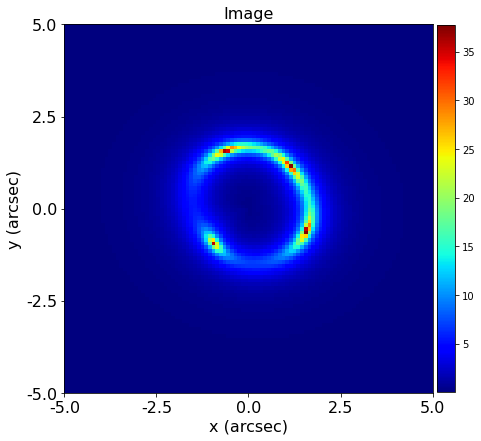

In [5]:
tracer_plotter = aplt.TracerPlotter(tracer=tracer, grid=grid)
tracer_plotter.figures(image=True)

To simulate the `Imaging` data, we don't use the image plotted above. Instead, we use an image which has been generated
specifically for simulating an image, which pads the array it is computed on based on the shape of the PSF we
convolve the image with. This ensures edge-effects do not degrade our simulation`s PSF convolution.

In [6]:
normal_image = tracer.image_from_grid(grid=grid)
padded_image = tracer.padded_image_from_grid_and_psf_shape(
    grid=grid, psf_shape_2d=psf.shape_native
)

print(normal_image.shape_native)
print(padded_image.shape_native)

(100, 100)
(110, 110)


Now, to simulate the `Imaging` data, we pass the `Tracer` and `Grid2D` to the `Imaging` module`s simulate function. 
This adds the following effects to the image:

 1) Telescope optics: Using the Point Spread Function above.
 2) The Background Sky: Although the image that is returned is automatically background sky subtracted.
 3) Poisson noise: Due to the background sky, lens galaxy and source galaxy Poisson photon counts.

In [7]:
simulator = al.SimulatorImaging(
    exposure_time=300.0, psf=psf, background_sky_level=0.1, add_poisson_noise=True
)

imaging = simulator.from_tracer_and_grid(tracer=tracer, grid=grid)

Lets plot the image. We can see the image has been blurred due to the telescope optics and noise has been added.

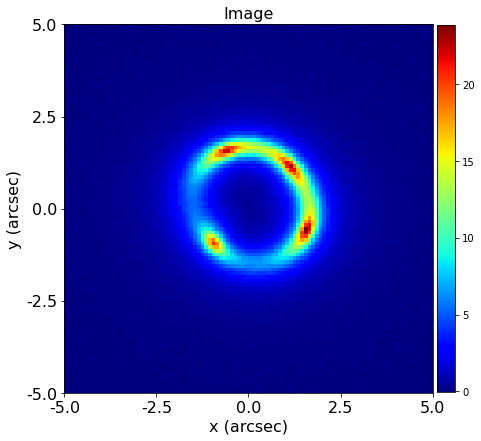

In [8]:
imaging_plotter = aplt.ImagingPlotter(imaging=imaging)
imaging_plotter.figures(image=True)

We'll now output these files to .fits files, we'll begin to analyze them in the next tutorial!

The `dataset_path` specifies where the data is output, this time in the directory 
`autolens_workspace/dataset/imaging/no_lens_light/howtolens/`, which contains many example images of strong lens distributed with the
`autolens_workspace`..

In [9]:
dataset_path = path.join("dataset", "imaging", "no_lens_light", "howtolens")
print("Dataset Path: ", dataset_path)

Dataset Path:  dataset/imaging/no_lens_light/howtolens


Now output our simulated data to hard-disk.

In [10]:
imaging.output_to_fits(
    image_path=path.join(dataset_path, "image.fits"),
    noise_map_path=path.join(dataset_path, "noise_map.fits"),
    psf_path=path.join(dataset_path, "psf.fits"),
    overwrite=True,
)

Finish.